In [3]:
import torch
from transformers import BeitFeatureExtractor, BeitForImageClassification
from torch.utils.data import random_split, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
from tqdm.notebook import tqdm

from dataset import FullLocationWithGridDataset
from geoguessr import HaversineLoss, Combined_Predictor

In [3]:
print(torch.cuda.is_available())

True


In [4]:
feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-384')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-384').to("cuda")

model.classifier = Combined_Predictor()
# model.classifier = torch.nn.Linear(768, 2).to("cuda")

In [5]:
checkpoint = torch.load("../models/model_glued_epoch_8.pt")

checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'best_val_loss', 'train_losses', 'train_class_losses', 'train_coord_losses', 'val_losses', 'val_class_losses', 'val_coord_losses', 'train_haversine', 'val_haversine'])

In [16]:
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

for param in model.parameters():
    param.requires_grad = False

AttributeError: '_IncompatibleKeys' object has no attribute 'to'

In [7]:
df = pd.read_csv("../data/annotations_glued.csv")

df[['lat', 'lon']].describe()

,lat,lon
count,17600.000000,17600.000000
mean,45.651843,7.945692
std,4.651038,9.333093
min,36.066402,-9.464124
25%,41.999797,-0.306321
50%,45.770447,8.059136
75%,49.110363,16.272085
max,54.829307,24.115109


<Axes: ylabel='Density'>

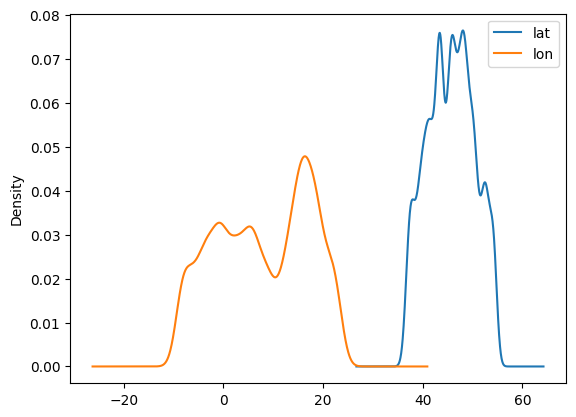

In [9]:
df[['lat', 'lon']].plot(kind="density")

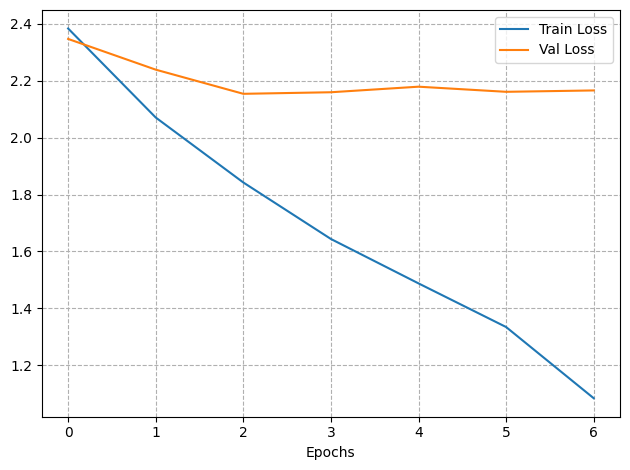

In [8]:
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

fig, ax = plt.subplots()

ax.plot(train_losses[1:], label="Train Loss")
ax.plot(val_losses[1:], label='Val Loss')

ax.set_xlabel("Epochs")

ax.grid(ls='--')
ax.legend()

fig.tight_layout()

In [9]:
torch.manual_seed(42)

dataset = FullLocationWithGridDataset("../data/annotations_glued.csv")

train_set, _, test_set = random_split(dataset, [0.8, 0.1, 0.1])

train_loader = DataLoader(train_set, batch_size=32, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, num_workers=2, shuffle=False, pin_memory=True)

In [10]:
criterion = HaversineLoss()

In [13]:
MEAN_LAT = 45.65404757
MEAN_LON = 7.95102084
STD_LAT = 4.644684882
STD_LON = 9.326391596

In [14]:
def standardizeLabels(labels):
    latitudes = labels[:, 0]
    longtitudes = labels[:, 1]

    latitudes = (latitudes - MEAN_LAT) / STD_LAT
    longtitudes = (longtitudes - MEAN_LON) / STD_LON

    labels[:, 0] = latitudes
    labels[:, 1] = longtitudes

    return labels


def unstandardizeLabels(labels):
    latitudes = labels[:, 0]
    longtitudes = labels[:, 1]

    latitudes = latitudes * STD_LAT + MEAN_LAT
    longtitudes = longtitudes * STD_LON + MEAN_LON

    labels[:, 0] = latitudes
    labels[:, 1] = longtitudes

    return labels

In [12]:
for images, labels in tqdm(test_loader):
    standardizeLabels(labels)
    unstandardizeLabels(labels)

  0%|          | 0/55 [00:00<?, ?it/s]

NameError: name 'MEAN_LAT' is not defined

In [12]:
n = 0
sum_lon = 0
sum_lat = 0
sum_sq_lon = 0
sum_sq_lat = 0

for _, labels in tqdm(train_loader):
    latitudes = labels[:, 0].detach()
    longtitudes = labels[:, 1].detach()

    n += latitudes.nelement()
    sum_lon += longtitudes.sum().item()
    sum_lat += latitudes.sum().item()
    sum_sq_lon += torch.pow(longtitudes, 2).sum().item()
    sum_sq_lat += torch.pow(latitudes, 2).sum().item()

  0%|          | 0/440 [00:00<?, ?it/s]

In [13]:
mean_lon = sum_lon / n
mean_lat = sum_lat / n

var_lon = (sum_sq_lon - sum_lon**2 / n) / (n - 1)
var_lat = (sum_sq_lat - sum_lat**2 / n) / (n - 1)

mean_lon, mean_lat, var_lon, var_lat

(7.932372688705271, 45.66534169803966, 87.40131680856707, 21.73401025781489)

In [14]:
var_lon**0.5, var_lat**0.5

(9.348867140384822, 4.661974931058177)

In [18]:
test_loss_batches = []
model.to("cuda")

for images, labels in tqdm(test_loader):
    with torch.no_grad():
        model.eval()
        labels = labels.cuda(non_blocking=True)

        features = feature_extractor(images, return_tensors="pt")
        features = features['pixel_values'].cuda(non_blocking=True)

        y_pred = model(features)
        y_pred_rescaled = unstandardizeLabels(y_pred.logits.detach())
        print(y_pred_rescaled.shape)
        print(labels.shape)
        print("_____")

        loss = criterion(y_pred_rescaled, labels[:,:2])
        test_loss_batches.append(loss.item())

  0%|          | 0/55 [00:00<?, ?it/s]

torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____
torch.Size([32, 2])
torch.Size([32, 3])
_____


KeyboardInterrupt: 

In [18]:
mean_loss = np.mean(test_loss_batches)

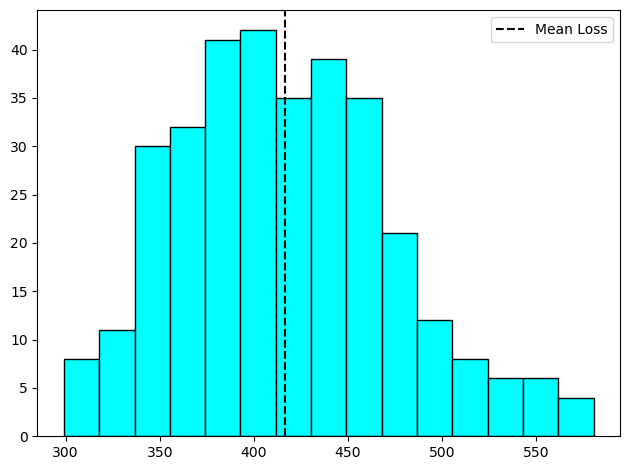

In [21]:
fig, ax = plt.subplots()

ax.hist(test_loss_batches, edgecolor='black', bins=15, color='cyan')

ax.axvline(mean_loss, ls='--', color='black', label='Mean Loss')

ax.legend()

fig.tight_layout()